# Exploratory Data Analysis

### The exploratory data ananlysis consists of 4 parts as shown below: <br>

Assumption: The first record of each article occurs on the day when the article is released. <br>

0. General Exploration on all articles and visitors<br>
a. The page visits pattern <br>
b. The numbers of and page visits from new/former articles/visitors in every 13 days in the training set <br>
c. The 4 compositions of page visits in every 13 days

1. Popularity (page visits) analysis on individual articles<br>
a. Page visits of each articles<br>
How many page visits could an article have during the first 65 days? <br>
b. Page visits of each articles for individual visitors <br>
How many times does an individual visitor read the same article during the first 65 days?

2. Popularity span (number of days between first visit ~ last visit) on individual articles <br>
a. Popularity span distribution for articles whose last records are before 2018-09-03 <br>
b. Popularity span distribution for articles whose last records are 2018-09-03 <br>
c. Popularity span distribution for popular articles (page visits > 57) <br>
d. Popularity span distribution for common articles (page visits < 57) <br>


4. Article content ananlysis <br>
a. Article headline features: the information in the article headlines <br>
b. Article category features: the information in the article categories <br>

In [661]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [597]:
# train_df = pd.read_csv('../data/cleaned/train_df.csv')
# train_df['visitDateTime'] = pd.to_datetime(train_df['visitDateTime'])
# train_df.head()
%store -r train_df

In [598]:
train_df.head()

,contentID,headline,categories,visitID,visitorID,visitDateTime,releaseDateTime
0,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas",1530421855,5.364833e+18,2018-07-01,2018-06-30
1,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas",1530421855,5.364833e+18,2018-07-01,2018-06-30
2,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas",1530421855,5.364833e+18,2018-07-01,2018-06-30
3,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas",1530421855,5.364833e+18,2018-07-01,2018-06-30
4,www.arkansasonline.com/news/2018/jun/30/suspec...,Suspect arrested in fatal shooting in Pulaski ...,/News/Arkansas/Crime,1530422162,9.015515e+18,2018-07-01,2018-06-30


In [599]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199663 entries, 0 to 199662
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   contentID        199663 non-null  object 
 1   headline         199663 non-null  object 
 2   categories       199663 non-null  object 
 3   visitID          199663 non-null  int64  
 4   visitorID        199663 non-null  float64
 5   visitDateTime    199663 non-null  object 
 6   releaseDateTime  199663 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 10.7+ MB


In [600]:
train_df['visitorID'].nunique()

2884

In [656]:
min(train_df['releaseDateTime'])

datetime.date(2000, 5, 10)

In [601]:
# user profile for train set
train_utility = train_df[['visitorID','contentID','visitDateTime', 'releaseDateTime']]
train_utility.head()

,visitorID,contentID,visitDateTime,releaseDateTime
0,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01,2018-06-30
1,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01,2018-06-30
2,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01,2018-06-30
3,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01,2018-06-30
4,9.015515e+18,www.arkansasonline.com/news/2018/jun/30/suspec...,2018-07-01,2018-06-30


## 0. General exploration <br>
### a. The page visits pattern

In [602]:
train_utility['weekday'] = pd.to_datetime(train_utility['visitDateTime']).dt.day_name().tolist()

daily_df = train_utility.groupby(['weekday','visitDateTime']).count()
daily_df.reset_index(inplace=True)
daily_df = daily_df.set_index('visitDateTime')
daily_df

<ipython-input-602-c4ab0af8000a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_utility['weekday'] = pd.to_datetime(train_utility['visitDateTime']).dt.day_name().tolist()


,weekday,visitorID,contentID,releaseDateTime
visitDateTime,,,,
2018-07-06,Friday,2448,2448,2448
2018-07-13,Friday,3588,3588,3588
2018-07-20,Friday,3954,3954,3954
2018-07-27,Friday,3520,3520,3520
2018-08-03,Friday,3769,3769,3769
...,...,...,...,...
2018-08-01,Wednesday,3895,3895,3895
2018-08-08,Wednesday,3790,3790,3790
2018-08-15,Wednesday,3215,3215,3215


In [603]:
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday']
weeday_mean = daily_df.groupby('weekday').mean().reindex(weekdays) 
weeday_mean

,visitorID,contentID,releaseDateTime
weekday,,,
Sunday,1765.700000,1765.700000,1765.700000
Monday,3234.500000,3234.500000,3234.500000
Tuesday,3484.222222,3484.222222,3484.222222
Wednesday,3751.777778,3751.777778,3751.777778
Thursday,3858.888889,3858.888889,3858.888889
Friday,3635.000000,3635.000000,3635.000000
Saturday,1899.111111,1899.111111,1899.111111


Text(0.5, 1.0, 'Average page visits during a week')

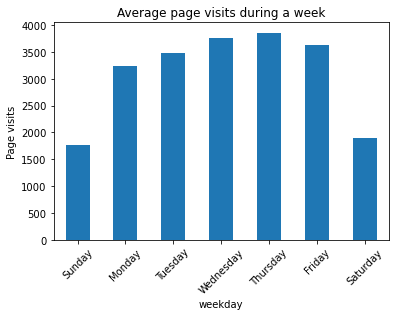

In [604]:
weekday_visits = weeday_mean['visitorID'] 
weekday_visits.plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Page visits')
plt.title('Average page visits during a week')

Generally speaking, page visits are lower during the weekends and are highest on Thursday.

Text(0.5, 1.0, 'Daily page visits')

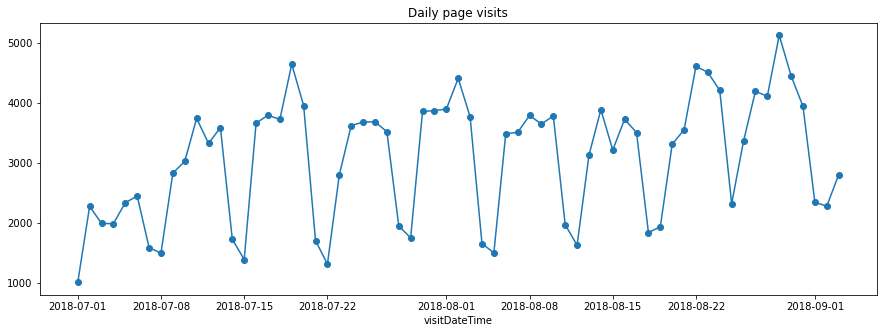

In [605]:
daily_visits = daily_df['visitorID']
daily_visits.plot(figsize = (15,5),marker="o")
plt.title("Daily page visits")

We can notice that the page visits follow a weekly and seasonal pattern.
We can try to find the variations during a week in general.

### b. The numbers of and page visits from new/former articles/visitors in every 13 days in the training set 
Next, I want to see, in every 13 days, how many page visits are from new articles and new visitors.

In [606]:
# define a function to split the training set into 5 intervals
end0 = pd.to_datetime('2018-07-01')
end1 = pd.to_datetime('2018-07-13')
end2 = pd.to_datetime('2018-07-26')
end3 = pd.to_datetime('2018-08-08')
end4 = pd.to_datetime('2018-08-21')
end5 = pd.to_datetime('2018-09-03')
end_dates = [end0, end1, end2, end3, end4, end5]

def interval(train_df):
    interval_1 = train_df[train_df['visitDateTime'] <= end1].reset_index(drop = True)
    interval_2 = train_df[(train_df['visitDateTime'] <= end2) & (train_df['visitDateTime'] > end1)].reset_index(drop = True).reset_index(drop = True)
    interval_3 = train_df[(train_df['visitDateTime'] <= end3) & (train_df['visitDateTime'] > end2)].reset_index(drop = True).reset_index(drop = True)
    interval_4 = train_df[(train_df['visitDateTime'] <= end4) & (train_df['visitDateTime'] > end3)].reset_index(drop = True).reset_index(drop = True)
    interval_5 = train_df[(train_df['visitDateTime'] <= end5) & (train_df['visitDateTime'] > end4)].reset_index(drop = True).reset_index(drop = True)
    interval_lists = [interval_1, interval_2, interval_3, interval_4, interval_5]
    return interval_lists

In [607]:
# define a function that finds the intersection between two lists
def intersection(lst1, lst2): 
    lst3 = [value for value in lst2 if value in lst1] 
    return lst3 

Have a look at the number of new/former articles and corresponding page visits

In [685]:
# define a function to find the number of new articles/visitors and corresponding page visitis in every 13 days 
def new_former(interval_lists, ID, item):
    
    former_a = interval_lists[0][ID].unique().tolist()
    
    former_a_counts = []
    new_a_counts = []
    former_ap_counts = []
    new_ap_counts = []

    print(f"There are {len(interval_lists[0][ID].unique())} {item} in interval {1}")
    print(f"There are {len(interval_lists[0])} visits in interval {1}")
    print('---------------')
    if ID == 'contentID':
        for i in range(1,5):
            interval_df = interval_lists[i]
            
            start_date = end_dates[i]
            end_date = end_dates[i+1]
            print('start:', start_date)
            print('end:', end_date)
            
            # select new artciels released in this time interval
            new_a = interval_df[(interval_df['releaseDateTime'] <= end_date) & (interval_df['releaseDateTime'] >= start_date)]['contentID'].unique().tolist()
            new_a_count = len(new_a)
            
            total_a_count = len(interval_df['contentID'].unique().tolist())
            former_a_count = total_a_count - new_a_count

            # the number of new articles and former articles in this time interval
            former_a_counts.append(former_a_count)
            new_a_counts.append(new_a_count)

            # the number of page visits from new articles and former articles in this time interval
            new_ap_count = len(interval_df[interval_df[ID].isin(new_a)])
            former_ap_count = len(interval_df) - new_ap_count
            
            former_ap_counts.append(former_ap_count)
            new_ap_counts.append(new_ap_count)

            print(f"There are {len(interval_df[ID].unique())} {item} in interval {i+1}")
            print(f"{former_a_count} former {item}, bringing {former_ap_count} visits; \n{new_a_count} new {item}, bringing {new_ap_count} visits")
            print('---------------')
            
    elif ID == 'visitorID':
        for i in range(1,5):
            interval_df = interval_lists[i]
            last_interval_df = interval_lists[i-1]

            former_a = former_a + last_interval_df[ID].unique().tolist()
            former_a = intersection(former_a, interval_df[ID].unique().tolist())
            former_a_count = len(former_a)
            new_a_count = interval_df[ID].nunique() - former_a_count


            # the number of new articles and former articles in this time interval
            former_a_counts.append(former_a_count)
            new_a_counts.append(new_a_count)

            # the number of page visits from new articles and former articles in this time interval
            former_ap_count = len(interval_df[interval_df[ID].isin(former_a)])
            new_ap_count = len(interval_df) - former_ap_count
            former_ap_counts.append(former_ap_count)
            new_ap_counts.append(new_ap_count)

            print(f"There are {len(interval_df[ID].unique())} {item} in interval {i+1}")
            print(f"{former_a_count} former {item}, bringing {former_ap_count} visits; \n{new_a_count} new {item}, bringing {new_ap_count} visits")
            print('---------------')
        
    return [former_a_counts, new_a_counts, former_ap_counts, new_ap_counts]

In [686]:
interval_lists = interval(train_df)

In [687]:
%store interval_lists

Stored 'interval_lists' (list)


In [688]:
article_lists = new_former(interval_lists, 'contentID', 'articles')
visitor_lists = new_former(interval_lists, 'visitorID', 'visitors')

There are 1931 articles in interval 1
There are 31635 visits in interval 1
---------------
start: 2018-07-13 00:00:00
end: 2018-07-26 00:00:00
There are 2150 articles in interval 2
781 former articles, bringing 1653 visits; 
1369 new articles, bringing 38044 visits
---------------
start: 2018-07-26 00:00:00
end: 2018-08-08 00:00:00
There are 2132 articles in interval 3
773 former articles, bringing 1871 visits; 
1359 new articles, bringing 39089 visits
---------------
start: 2018-08-08 00:00:00
end: 2018-08-21 00:00:00
There are 1917 articles in interval 4
582 former articles, bringing 1219 visits; 
1335 new articles, bringing 37903 visits
---------------
start: 2018-08-21 00:00:00
end: 2018-09-03 00:00:00
There are 1840 articles in interval 5
455 former articles, bringing 1061 visits; 
1385 new articles, bringing 47188 visits
---------------
There are 1352 visitors in interval 1
There are 31635 visits in interval 1
---------------
There are 1502 visitors in interval 2
1012 former visi

In [689]:
# define a function to convert the data into dataframe
def DF(article_first_lists, articles):
    df = pd.DataFrame({f'Former {articles}':article_first_lists[0], 
                       f'New {articles}':article_first_lists[1], 
                       f'{articles.capitalize()} ratio (Former/New)':[round(i/j, 2) for i, j in zip(article_first_lists[0], article_first_lists[1])], 
                       f'Page visits from former {articles}':article_first_lists[2], 
                       f'Page visits from new {articles}':article_first_lists[3],
                      f'Page vitists ratio (Former/New visitors)':[round(i/j, 2) for i, j in zip(article_first_lists[2], article_first_lists[3])]})
    return df

In [690]:
print(f'{round(sum(article_lists[1])/(sum(article_lists[0])+sum(article_lists[1])),2)} of the articles are new articels on average')
print(f'{round(sum(article_lists[3])/(sum(article_lists[2])+sum(article_lists[3])),2)} of the pages visits are from new articles on average')
DF(article_lists, 'articles')

0.68 of the articles are new articels on average
0.97 of the pages visits are from new articles on average


,Former articles,New articles,Articles ratio (Former/New),Page visits from former articles,Page visits from new articles,Page vitists ratio (Former/New visitors)
0,781,1369,0.57,1653,38044,0.04
1,773,1359,0.57,1871,39089,0.05
2,582,1335,0.44,1219,37903,0.03
3,455,1385,0.33,1061,47188,0.02


In [691]:
print(f'{round(sum(visitor_lists[1])/(sum(visitor_lists[0])+sum(visitor_lists[1]))*100,2)}% of the visitor are new visitors on average')
print(f'{round(sum(visitor_lists[3])/(sum(visitor_lists[2])+sum(visitor_lists[3]))*100,2)}% of the pages visits are from new visitors on average')
DF(visitor_lists, 'visitors')

30.62% of the visitor are new visitors on average
13.76% of the pages visits are from new visitors on average


,Former visitors,New visitors,Visitors ratio (Former/New),Page visits from former visitors,Page visits from new visitors,Page vitists ratio (Former/New visitors)
0,1012,490,2.07,33987,5710,5.95
1,1107,407,2.72,35777,5183,6.90
2,1118,559,2.00,32985,6137,5.37
3,1240,520,2.38,42159,6090,6.92


In [692]:
str((end1 + timedelta(days=1)).date())

In [733]:
# define a function to draw bar charts to compare the number of new articles/visitors and contributed page visits
labels = [f'{str((end1 + timedelta(days=1)).date())} ~ {end2.date()}',f'{str((end2 + timedelta(days=1)).date())} ~ {end3.date()}',f'{str((end3 + timedelta(days=1)).date())} ~ {end4.date()}',f'{str((end4 + timedelta(days=1)).date())} ~ {end5.date()}']

def new_former_plot(article_lists, visitor_lists):
    former_v_counts = visitor_lists[0]
    new_v_counts = visitor_lists[1]
    former_vp_counts = visitor_lists[2]
    new_vp_counts = visitor_lists[3]
    
    former_a_counts = article_lists[0]
    new_a_counts = article_lists[1]
    former_ap_counts = article_lists[2]
    new_ap_counts = article_lists[3]
    
    width = 0.35

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))

    ax1.bar(labels, new_a_counts, width, label='New articles')
    ax1.bar(labels, former_a_counts, width, bottom = new_a_counts, label='Former articles')
    ax1.set_ylabel('Articles')
    ax1.set_xlabel('Time intervals (every 13 days)')
    ax1.set_title('New articles and former articles in every 13 days (training set)')
    ax1.legend()

    ax2.bar(labels, new_ap_counts, width, label='New articles visits')
    ax2.bar(labels, former_ap_counts, width, bottom = new_ap_counts, label='Former articles visits')
    ax2.set_ylabel('Articles page visits')
    ax2.set_xlabel('Time intervals (every 13 days)')
    ax2.set_title('Page visits from new articles and former articles in every 13 days (training set)')
    ax2.legend()

    ax3.bar(labels, new_v_counts, width, label='New visitors')
    ax3.bar(labels, former_v_counts, width, bottom = new_v_counts, label='Former visitors')
    ax3.set_ylabel('Visitors')
    ax3.set_title('New visitors and former visitors in every 13 days (training set)')
    ax3.legend()

    ax4.bar(labels, new_vp_counts, width, label='New visitors visits')
    ax4.bar(labels, former_vp_counts, width, bottom = new_vp_counts, label='Former visitors visits')
    ax4.set_ylabel('Visitors page visits')
    ax4.set_title('Page visits from new visitors and former visitors in every 13 days (training set)')
    ax4.legend()

    plt.show()

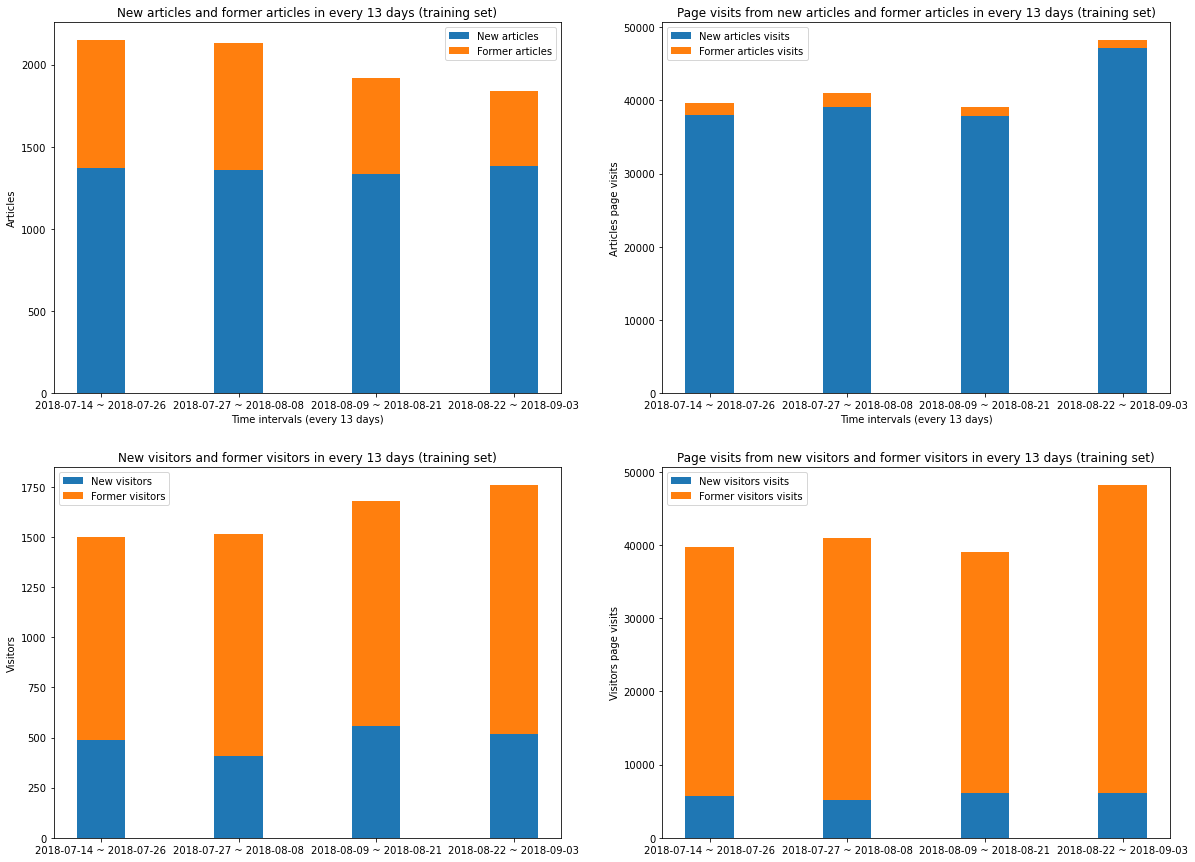

In [734]:
new_former_plot(article_lists, visitor_lists)

I also want to see if it will make any difference with only considering the first visit for each visitor to each article

In [735]:
train_first_df = train_df.drop_duplicates(subset = ['visitorID','contentID'], keep = 'first', inplace = False).reset_index(drop = True)
interval_first_lists = interval(train_first_df)

article_first_lists = new_former(interval_first_lists, 'contentID', 'articles')
visitor_first_lists = new_former(interval_first_lists, 'visitorID', 'visitors')

There are 1931 articles in interval 1
There are 17304 visits in interval 1
---------------
start: 2018-07-13 00:00:00
end: 2018-07-26 00:00:00
There are 2116 articles in interval 2
750 former articles, bringing 977 visits; 
1366 new articles, bringing 20504 visits
---------------
start: 2018-07-26 00:00:00
end: 2018-08-08 00:00:00
There are 2085 articles in interval 3
727 former articles, bringing 969 visits; 
1358 new articles, bringing 20218 visits
---------------
start: 2018-08-08 00:00:00
end: 2018-08-21 00:00:00
There are 1870 articles in interval 4
538 former articles, bringing 634 visits; 
1332 new articles, bringing 18915 visits
---------------
start: 2018-08-21 00:00:00
end: 2018-09-03 00:00:00
There are 1783 articles in interval 5
400 former articles, bringing 526 visits; 
1383 new articles, bringing 22834 visits
---------------
There are 1352 visitors in interval 1
There are 17304 visits in interval 1
---------------
There are 1497 visitors in interval 2
1007 former visitors

In [736]:
DF(article_first_lists, 'articles')

,Former articles,New articles,Articles ratio (Former/New),Page visits from former articles,Page visits from new articles,Page vitists ratio (Former/New visitors)
0,750,1366,0.55,977,20504,0.05
1,727,1358,0.54,969,20218,0.05
2,538,1332,0.40,634,18915,0.03
3,400,1383,0.29,526,22834,0.02


In [737]:
DF(visitor_first_lists, 'visitors')

,Former visitors,New visitors,Visitors ratio (Former/New),Page visits from former visitors,Page visits from new visitors,Page vitists ratio (Former/New visitors)
0,1007,490,2.06,18368,3113,5.90
1,1099,410,2.68,19061,2126,8.97
2,1111,560,1.98,16136,3413,4.73
3,1238,521,2.38,20271,3089,6.56


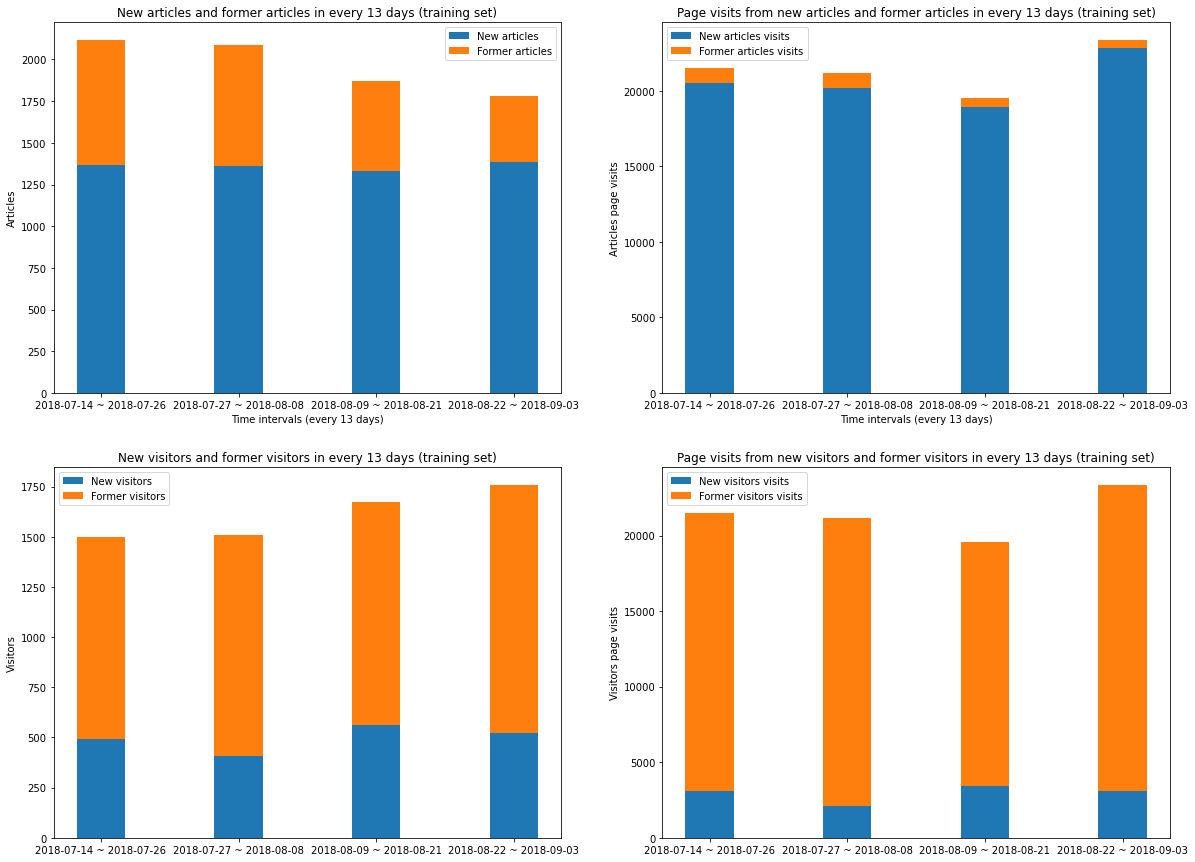

In [738]:
new_former_plot(article_first_lists, visitor_first_lists)

It doesn't make any difference if we only consider the first visit from each visitor to each article from the plot above.

#### From two plots above, it can be seen:

1. In every interval (13 days), most visited articles are new articles. Furthermore, the overwhelming majority of page visits are attributed to new articles. 
2. In every interval (13 days), most visitors are former visitors (2/3)

### c. The 4 compositions of page visits in every 13 days

In [739]:
# define a function to get the number of page visits from new/former visitors and new/previous articles in each time interval
def four_components(interval_lists):
    former_a = interval_lists[0]['contentID'].unique().tolist()
    former_v = interval_lists[0]['visitorID'].unique().tolist()
    na_nv_s = []
    fa_nv_s = []
    na_fv_s = []
    fa_fv_s = []

    print(f"There are {len(interval_lists[0])} visits in interval 1")
    print('---------------')

    for i in range(1,5):
        print(i)
        interval_df = interval_lists[i]
        last_interval_df = interval_lists[i-1]

        start_date = end_dates[i]
        end_date = end_dates[i+1]
        print('start:', start_date)
        print('end:', end_date)
        new_a = interval_df[(interval_df['releaseDateTime'] <= end_date) & (interval_df['releaseDateTime'] >= start_date)]['contentID'].unique().tolist()

        former_v = former_v + last_interval_df['visitorID'].unique().tolist()
        former_v = intersection(former_v, interval_df['visitorID'].unique().tolist())

        # the number of page visits from new/former articles/visitors in this time interval 
        total = len(interval_df)
        fa_p = len(interval_df[~interval_df['contentID'].isin(new_a)])
        fv_p = len(interval_df[interval_df['visitorID'].isin(former_v)])

        fa_fv = len(interval_df[~(interval_df['contentID'].isin(new_a)) & (interval_df['visitorID'].isin(former_v))])
        fa_nv = fa_p - fa_fv
        na_fv = fv_p - fa_fv
        na_nv = total - fa_fv - fa_nv - na_fv   

        na_nv_s.append(na_nv)
        fa_nv_s.append(fa_nv)
        na_fv_s.append(na_fv)
        fa_fv_s.append(fa_fv)                 

        print(f"{total}, fap{fa_p}, fvp{fv_p}, nanv{na_nv},  fanv{fa_nv}, nafv{na_fv}, fafv{fa_fv}")
        print('---------------')

    nfav = [na_nv_s, fa_nv_s, na_fv_s, fa_fv_s]
    return nfav

In [740]:
# define a function to draw stacked bar charts 
def four_components_plot(nfav):
    level2 = np.add(nfav[0], nfav[1]).tolist()
    level3 = np.add(level2, nfav[2]).tolist()

    plt.figure(figsize=(15, 8))
    plt.bar(labels, nfav[0], width, label="new articles + new visitors")
    plt.bar(labels, nfav[1], width, bottom = nfav[0], label="previous articles + new visitors")
    plt.bar(labels, nfav[2], width, bottom = level2, label="new articles + former visitors")
    plt.bar(labels, nfav[3], width, bottom = level3, label="previous articles + former visitors")
    plt.title('Page visits compositions')
    plt.xlabel('Intervals')
    plt.ylabel('Page visits')
    plt.legend()

In [741]:
# define a function to compute and to print the percent of page visits from each component
def four_components_percent(nfav):
    total_visits_sum = sum(nfav[0]) + sum(nfav[1]) + sum(nfav[2]) + sum(nfav[3])

    print(f'{round(sum(nfav[0])/(total_visits_sum)*100,2)}% of the page visits are from "new articles + new visitors"')
    print(f'{round(sum(nfav[1])/(total_visits_sum)*100,2)}% of the page visits are from "previous articles + new visitors"')
    print(f'{round(sum(nfav[2])/(total_visits_sum)*100,2)}% of the page visits are from "new articles + former visitors"')
    print(f'{round(sum(nfav[3])/(total_visits_sum)*100,2)}% of the page visits are from "previous articles + former visitors"')

There are 31635 visits in interval 1
---------------
1
start: 2018-07-13 00:00:00
end: 2018-07-26 00:00:00
39697, fap1653, fvp33987, nanv5355,  fanv355, nafv32689, fafv1298
---------------
2
start: 2018-07-26 00:00:00
end: 2018-08-08 00:00:00
40960, fap1871, fvp35777, nanv4918,  fanv265, nafv34171, fafv1606
---------------
3
start: 2018-08-08 00:00:00
end: 2018-08-21 00:00:00
39122, fap1219, fvp32985, nanv5881,  fanv256, nafv32022, fafv963
---------------
4
start: 2018-08-21 00:00:00
end: 2018-09-03 00:00:00
48249, fap1061, fvp42159, nanv5859,  fanv231, nafv41329, fafv830
---------------


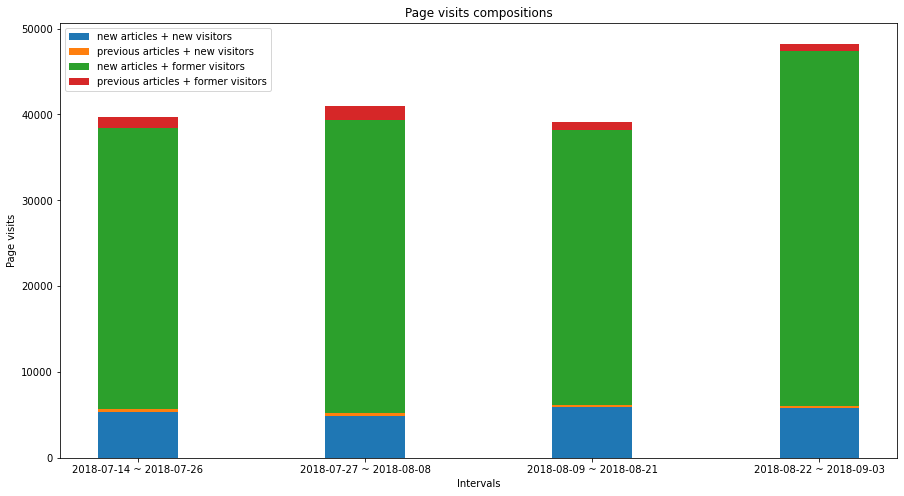

In [742]:
nfav = four_components(interval_lists)
four_components_plot(nfav)

In [743]:
four_components_percent(nfav)

13.1% of the page visits are from "new articles + new visitors"
0.66% of the page visits are from "previous articles + new visitors"
83.45% of the page visits are from "new articles + former visitors"
2.8% of the page visits are from "previous articles + former visitors"


Let's consider the first record from each visitor to each article only

There are 17304 visits in interval 1
---------------
1
start: 2018-07-13 00:00:00
end: 2018-07-26 00:00:00
21481, fap977, fvp18368, nanv2911,  fanv202, nafv17593, fafv775
---------------
2
start: 2018-07-26 00:00:00
end: 2018-08-08 00:00:00
21187, fap969, fvp19061, nanv1969,  fanv157, nafv18249, fafv812
---------------
3
start: 2018-08-08 00:00:00
end: 2018-08-21 00:00:00
19549, fap634, fvp16136, nanv3257,  fanv156, nafv15658, fafv478
---------------
4
start: 2018-08-21 00:00:00
end: 2018-09-03 00:00:00
23360, fap526, fvp20271, nanv2946,  fanv143, nafv19888, fafv383
---------------


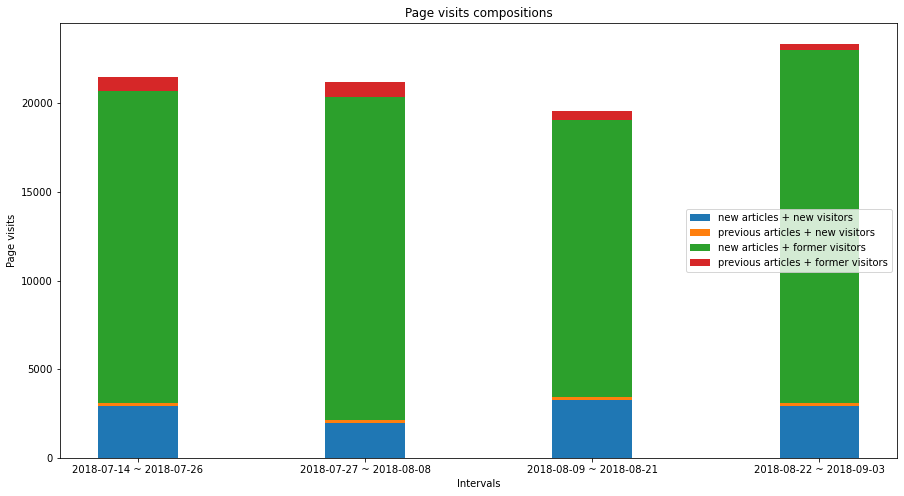

In [744]:
nfav_first = four_components(interval_first_lists)
four_components_plot(nfav_first)

In [745]:
four_components_percent(nfav_first)

12.95% of the page visits are from "new articles + new visitors"
0.77% of the page visits are from "previous articles + new visitors"
83.42% of the page visits are from "new articles + former visitors"
2.86% of the page visits are from "previous articles + former visitors"


#### The plots above suggetsts that:
Around 83% of page visits are from former visitors reading new articles, 13% from new visitors reading new articles, 3% from former visitors reading previous articles, 1% from new visitors reading previous articles. <br>
As a result, we should prioritize the recommendations as shown below: 

1. Recommendation of new articles to former visitors <br> 
ew articles that are silimilar to the articles the visitor has read (CF)
2. Recommendation of new articles to new visitors <br>
new articles that are popular among new articels recommended to former visitors (Popular on CF)
3. Recommendation of former articles to former visitors <br>
formder artiles that are popular or similar to the articles the visitor has read (Popular or CF)
4. Recommendation of former articles to new visitors <br> (Popular)
formder artiles that are popular


#### Next, I want to explore the popularity and popularity time span of each articles

### 1. Popularity distribution
#### a. Page visits of each articles <br>

Let's have a look at the total page views for each article to see how popular an article could get

In [746]:
popularity = train_utility.groupby('contentID').count()
popularity.columns = ['count1', 'count2', 'count3','count4']
popularity.sort_values('count1', ascending = False)

,count1,count2,count3,count4
contentID,,,,
www.arkansasonline.com/news/2018/aug/29/food-networks-diners-drive-ins-and-dives-stops-lit/,910,910,910,910
www.arkansasonline.com/news/2018/aug/31/former-arkansas-senator-jeremy-hutchinson-indicted/,734,734,734,734
www.arkansasonline.com/news/2018/aug/22/arkansas-democrat-gazette-delivery-man-shot-robbed/,656,656,656,656
www.arkansasonline.com/news/2018/jul/19/sheriff-8-people-dead-after-missouri-tourist-boat-/,594,594,594,594
www.arkansasonline.com/news/2018/aug/16/little-rock-police-helicopter-crashes-injuries-rep/,583,583,583,583
...,...,...,...,...
www.arkansasonline.com/news/2018/aug/12/look-for-1-of-big-3-to-win-in-michigan-/,1,1,1,1
www.arkansasonline.com/news/2018/aug/12/major-league-baseball-notes-20180812/,1,1,1,1
www.arkansasonline.com/news/2018/aug/12/mercy-earns-recognition-for-diabetes-pr/,1,1,1,1


In [747]:
popularity['count1'].describe() #(0,57)

count    8523.000000
mean       23.426376
std        47.866476
min         1.000000
25%         2.000000
50%         6.000000
75%        24.000000
max       910.000000
Name: count1, dtype: float64

Text(0.5, 1.0, 'The views distribution for all the articles in the traing set')

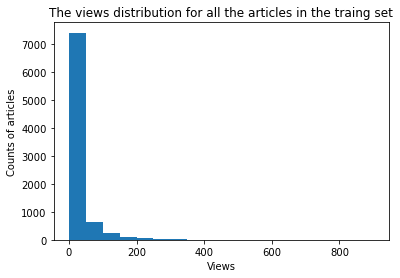

In [748]:
plt.hist(popularity['count1'], bins = range(0,950,50))
plt.xlabel('Views')
plt.ylabel('Counts of articles')
plt.title("The views distribution for all the articles in the traing set")

It can be seen that most articles have page visits between 0 and 50. The upperlimit for page visits = Q3+1.5IQR = 24+1.5*22 = 57. As a result, articles with page visits more than 57 could be considered as popular articles.

#### b. Page visits of each articles for individual visitors <br>
How many times does an individual visitor read the same article during the first 65 days?

In [749]:
popular_ind = train_df.groupby(['visitorID','contentID']).count().sort_values('headline', ascending = False)
popular_ind.head()

headline  \
visitorID    contentID                                                      
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...       196   
             www.arkansasonline.com/news/2018/sep/02/white-f...       180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...       132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...       124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...       120   

                                                                 categories  \
visitorID    contentID                                                        
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...         196   
             www.arkansasonline.com/news/2018/sep/02/white-f...         180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...         132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...         124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...         120   

                                                                 visitID  \
visitorID    contentID                                                     
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...      196   
             www.arkansasonline.com/news/2018/sep/02/white-f...      180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...      132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...      124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...      120   

                                                                 visitDateTime  \
visitorID    contentID                                                           
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...            196   
             www.arkansasonline.com/news/2018/sep/02/white-f...            180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...            132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...            124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...            120   

                                                                 releaseDateTime  
visitorID    contentID                                                            
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...              196  
             www.arkansasonline.com/news/2018/sep/02/white-f...              180  
             www.arkansasonline.com/news/2018/aug/03/obama-s...              132  
             www.arkansasonline.com/news/2018/aug/10/cotton-...              124  
             www.arkansasonline.com/news/2018/aug/24/cotton-...              120

In [750]:
popular_ind_avg = pd.DataFrame(popular_ind.groupby('visitorID')['headline'].mean().sort_values(ascending=False))
popular_ind_avg.columns = ['avg_views']
popular_ind_avg

,avg_views
visitorID,
5.393418e+18,32.000000
5.899972e+18,17.454545
4.720442e+18,16.290323
4.424965e+18,16.257143
4.238538e+18,16.000000
...,...
2.852333e+18,1.000000
8.328446e+18,1.000000
2.856705e+18,1.000000


In [751]:
popular_ind_avg['avg_views'].describe()

count    2884.000000
mean        1.877534
std         1.705951
min         1.000000
25%         1.000000
50%         1.047810
75%         1.539263
max        32.000000
Name: avg_views, dtype: float64

Text(0.5, 1.0, 'The average views for individual visitors')

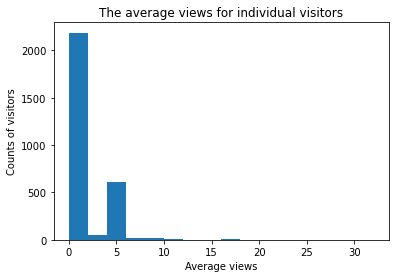

In [752]:
plt.hist(popular_ind_avg['avg_views'], bins = range(0,33,2))
plt.xlabel('Average views')
plt.ylabel('Counts of visitors')
plt.title("The average views for individual visitors")

For each visitor, the average view for each article is 2 views and most visitors don't read the same article for more than 1.5 times. As a result, it is reasonable to recommend articles that individual visitors haven't read instead of repeatedly recommending articles they have read.

### 2. Popularity span distribution for all the articles

We could have a look at the popularity span of all the articles to see how long the effects from each article could last.

In [753]:
article_lag = pd.DataFrame(train_utility.groupby('contentID')['visitDateTime']
                           .agg(np.ptp)).sort_values('visitDateTime', ascending = False)
article_lag = article_lag.rename(columns={'visitDateTime':'lag'})
article_lag.head()

,lag
contentID,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60 days
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59 days
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58 days
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58 days
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58 days


In [754]:
article_s_e = train_utility.groupby('contentID').agg({'visitDateTime': ['min', 'max', 'count']}) 
article_s_e.columns = ['min','max','count']
article_s_e.head()

,min,max,count
contentID,,,
www.arkansasonline.com/news/2000/may/10/gun-maker-grandfather-dropped-school-shooting-suit/,2018-07-18,2018-07-18,2
www.arkansasonline.com/news/2007/aug/10/restaurants-thrill-grill-fades-butcher-sh-20070810/,2018-07-25,2018-07-25,1
www.arkansasonline.com/news/2007/dec/15/personal-space-20071215/,2018-08-09,2018-08-09,1
www.arkansasonline.com/news/2007/feb/17/our-town-north-little-rock-notebook-20070217/,2018-08-09,2018-08-09,1
www.arkansasonline.com/news/2007/jul/29/summary-2007-general-session-arkansas-legislature/,2018-07-23,2018-07-23,1


In [755]:
# the number of days between the first visit and the last visit, the total visits.
article_s_e.sort_values('count', ascending = False)

,min,max,count
contentID,,,
www.arkansasonline.com/news/2018/aug/29/food-networks-diners-drive-ins-and-dives-stops-lit/,2018-08-29,2018-09-03,910
www.arkansasonline.com/news/2018/aug/31/former-arkansas-senator-jeremy-hutchinson-indicted/,2018-08-31,2018-09-03,734
www.arkansasonline.com/news/2018/aug/22/arkansas-democrat-gazette-delivery-man-shot-robbed/,2018-08-22,2018-08-28,656
www.arkansasonline.com/news/2018/jul/19/sheriff-8-people-dead-after-missouri-tourist-boat-/,2018-07-20,2018-08-01,594
www.arkansasonline.com/news/2018/aug/16/little-rock-police-helicopter-crashes-injuries-rep/,2018-08-16,2018-08-21,583
...,...,...,...
www.arkansasonline.com/news/2018/aug/12/look-for-1-of-big-3-to-win-in-michigan-/,2018-08-12,2018-08-12,1
www.arkansasonline.com/news/2018/aug/12/major-league-baseball-notes-20180812/,2018-08-12,2018-08-12,1
www.arkansasonline.com/news/2018/aug/12/mercy-earns-recognition-for-diabetes-pr/,2018-08-13,2018-08-13,1


In [756]:
articles_s_e_l = pd.merge(article_lag, article_s_e, on = ('contentID'), how = 'inner')
articles_s_e_l.columns = ['lag','min','max','count']
articles_s_e_l['lag'] = pd.to_numeric(articles_s_e_l['lag'].dt.days, downcast='integer')
articles_s_e_l.sort_values('count', ascending = False).head(20)

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/aug/29/food-networks-diners-drive-ins-and-dives-stops-lit/,5,2018-08-29,2018-09-03,910
www.arkansasonline.com/news/2018/aug/31/former-arkansas-senator-jeremy-hutchinson-indicted/,3,2018-08-31,2018-09-03,734
www.arkansasonline.com/news/2018/aug/22/arkansas-democrat-gazette-delivery-man-shot-robbed/,6,2018-08-22,2018-08-28,656
www.arkansasonline.com/news/2018/jul/19/sheriff-8-people-dead-after-missouri-tourist-boat-/,12,2018-07-20,2018-08-01,594
www.arkansasonline.com/news/2018/aug/16/little-rock-police-helicopter-crashes-injuries-rep/,5,2018-08-16,2018-08-21,583
www.arkansasonline.com/news/2018/aug/25/salt-bowl-game-hold-after-fight-war-memorial-stadi/,7,2018-08-26,2018-09-02,565
www.arkansasonline.com/news/2018/aug/27/3-inmates-found-dead-arkansas-prison/,4,2018-08-27,2018-08-31,551
www.arkansasonline.com/news/2018/aug/29/2-more-inmates-die-arkansas-prison-official-says-b/,5,2018-08-29,2018-09-03,506
www.arkansasonline.com/news/2018/aug/29/2-killed-head-collision-little-rock-car-was-drivin/,4,2018-08-29,2018-09-02,500


In [757]:
articles_s_e_l.sort_values('lag', ascending = False)

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59,2018-07-01,2018-08-29,16
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58,2018-07-02,2018-08-29,5
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58,2018-07-02,2018-08-29,7
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99
...,...,...,...,...
www.arkansasonline.com/news/2018/jun/18/officials-doctor-worked-arkansas-va-hospital-while/,0,2018-07-13,2018-07-13,1
www.arkansasonline.com/news/2018/jul/21/golfers-get-kicks-in-after-open-rounds-/,0,2018-07-21,2018-07-21,3
www.arkansasonline.com/news/2018/jun/21/crawford-calls-tariffs-a-boon-for-farme/,0,2018-07-04,2018-07-04,4



It can be inferred that most page visits are attributed to the page visits from popular articles when they are newly released instead of the page visits from less popular articles accumulated during a long time.

#### a. Popularity span distribution for the articles whose records are before the end day of the training period (2018-09-03)

First, have a look at the articles whose last records are before the end day (2018-09-03) of training set 

In [758]:
training_before_last_day = articles_s_e_l.loc[articles_s_e_l['max'] < pd.to_datetime('2018-09-03')]
training_before_last_day

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59,2018-07-01,2018-08-29,16
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58,2018-07-02,2018-08-29,5
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58,2018-07-02,2018-08-29,7
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99
...,...,...,...,...
www.arkansasonline.com/news/2018/aug/26/splitting-dinner-bills-tricky-separate-/,0,2018-08-26,2018-08-26,4
www.arkansasonline.com/news/2018/aug/26/s-korea-urges-u-s-north-to-keep-talking/,0,2018-08-26,2018-08-26,6
www.arkansasonline.com/news/2018/aug/26/road-to-becoming-physician-starts-with-/,0,2018-08-26,2018-08-26,15


In [759]:
# training_before_last_day.to_csv('../data/cleaned/span.csv')

In [760]:
training_before_last_day['lag'].describe()

count    8332.000000
mean        2.950312
std         6.952601
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        60.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for articles whose last records are before 2018-09-03')

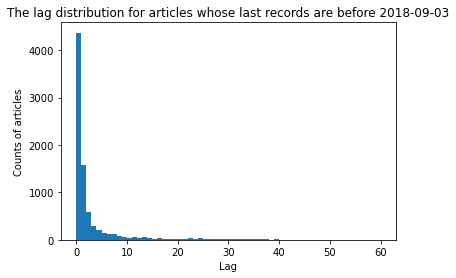

In [761]:
plt.hist(training_before_last_day['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of articles')
plt.title("The lag distribution for articles whose last records are before 2018-09-03")

It is obvious that the effects of most articles last for 0-2 days, which means that users are likely to view new-released articles instead of articles that have published for a long time.

#### b. Popularity span distribution for the articles whose records are the end day of the training period
Then, have a look at the articles whose last records are the end day (2018-09-03) of training set to see if there is any difference. 

In [762]:
training_last_day = articles_s_e_l.loc[articles_s_e_l['max'] == pd.to_datetime('2018-09-03')]
training_last_day.head()

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/24/indiana-man-stabbed-north-little-rock-homeless-cam/,41,2018-07-24,2018-09-03,96
www.arkansasonline.com/news/2018/jul/29/cannabis-question-is-college-a-school-2-1/,36,2018-07-29,2018-09-03,131
www.arkansasonline.com/news/2018/aug/05/1-dead-3-injured-after-boat-capsizes-river-arkansa/,29,2018-08-05,2018-09-03,215
www.arkansasonline.com/news/2018/aug/06/state-s-medicaid-spending-falls-off-201/,28,2018-08-06,2018-09-03,192
www.arkansasonline.com/news/2018/aug/15/arkansas-man-accused-imprisoning-beating-woman-sen/,19,2018-08-15,2018-09-03,71


In [763]:
training_last_day['lag'].describe()

count    191.000000
mean       2.701571
std        5.704103
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       41.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for articles whose last records are on 2018-09-03')

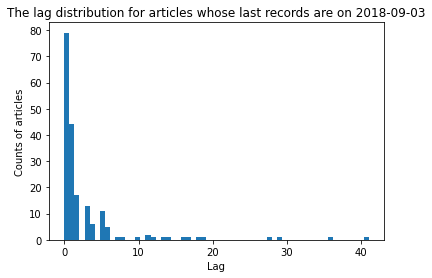

In [764]:
plt.hist(training_last_day['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of articles')
plt.title("The lag distribution for articles whose last records are on 2018-09-03")

As can be seen, it still follows the same distribution. <br> As a result, it is safe to say that most articles only have short effects which last for 0-3 days.

#### c. Polularity span for popular articles

Then, let's see if there is any difference in popularity distributions for popular articles and common articles.

In [765]:
articles_s_e_l.head()

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59,2018-07-01,2018-08-29,16
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58,2018-07-02,2018-08-29,5
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58,2018-07-02,2018-08-29,7
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99


In [766]:
popular_articles = articles_s_e_l.loc[articles_s_e_l['count'] > 57]
popular_articles

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99
www.arkansasonline.com/news/2018/jul/05/photos-blaze-damaged-arkansas-home-was-started-fir/,55,2018-07-05,2018-08-29,63
www.arkansasonline.com/news/2018/jul/06/burges-opens-third-location-conway/,54,2018-07-06,2018-08-29,168
www.arkansasonline.com/news/2018/jul/07/hospital-ex-employee-subject-of-data-in/,53,2018-07-07,2018-08-29,109
...,...,...,...,...
www.arkansasonline.com/news/2018/aug/02/flight-to-concert-was-intent-of-plane-t/,0,2018-08-02,2018-08-02,73
www.arkansasonline.com/news/2018/aug/15/lawsuit-filed-on-work-rule-for-medicaid/,0,2018-08-15,2018-08-15,88
www.arkansasonline.com/news/2018/aug/08/eatery-worker-s-illness-prompts-new-hea-1/,0,2018-08-08,2018-08-08,62


There are 899 popular articles in the training set (page views > 57, which is the upperlimit)

In [767]:
popular_des = popular_articles['lag'].describe()
popular_des

count    897.000000
mean       6.632107
std        8.711304
min        0.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       60.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for popular articles (counts > 57)')

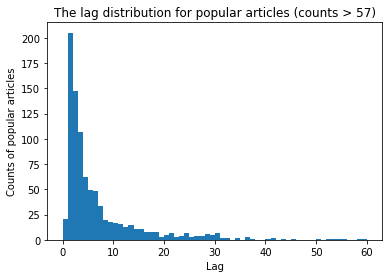

In [768]:
plt.hist(popular_articles['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of popular articles')
plt.title("The lag distribution for popular articles (counts > 57)")

For popular articles, the average lag is longer, about 7 days, but still not that long.

#### d. Popularity span for common articles

In [769]:
common_articles = articles_s_e_l.loc[articles_s_e_l['count'] <= 57]
common_des = common_articles['lag'].describe()
common_des

count    7626.000000
mean        2.511015
std         6.551462
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        59.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for common articles (counts <= 57)')

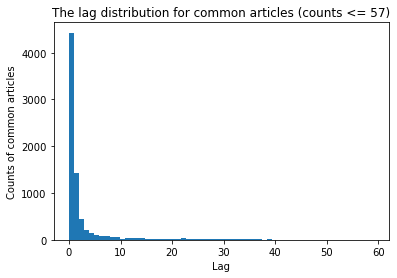

In [770]:
plt.hist(common_articles['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of common articles')
plt.title("The lag distribution for common articles (counts <= 57)")

Let's see if the lags for popular articles and for common articles follow the same distribution. 


In [771]:
common_des
popular_des
S_p_c = math.sqrt(popular_des['std']**2/popular_des['count']+common_des['std']**2/common_des['count'])
t_popularity = abs(popular_des['mean']-common_des['mean'])/S_p_c
t_popularity
print(f"The t value is {round(t_popularity,2)}, which is much larger than the critical t value (1.96). It means that the article views for popular articles and common articles follow different distributions")

The t value is 13.72, which is much larger than the critical t value (1.96). It means that the article views for popular articles and common articles follow different distributions


Aa a result, it may be reasonable to recommend former popular articles even after a week from the day the article is released, but for common articles, the effects normally last only 0-2.5 days.

PS: please click into '2_2_EDA_NLP.ipynb' to have a look at the 4th part of exploratory data analysis